## <small>
Copyright (c) 2017-21 Andrew Glassner

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
</small>



# Deep Learning: A Visual Approach
## by Andrew Glassner, https://glassner.com
### Order: https://nostarch.com/deep-learning-visual-approach
### GitHub: https://github.com/blueberrymusic
------

### What's in this notebook

This notebook is provided as a “behind-the-scenes” look at code used to make some of the figures in this chapter. It is cleaned up a bit from the original code that I hacked together, and is only lightly commented. I wrote the code to be easy to interpret and understand, even for those who are new to Python. I tried never to be clever or even more efficient at the cost of being harder to understand. The code is in Python3, using the versions of libraries as of April 2021. 

This notebook may contain additional code to create models and images not in the book. That material is included here to demonstrate additional techniques.

Note that I've included the output cells in this saved notebook, but Jupyter doesn't save the variables or data that were used to generate them. To recreate any cell's output, evaluate all the cells from the start up to that cell. A convenient way to experiment is to first choose "Restart & Run All" from the Kernel menu, so that everything's been defined and is up to date. Then you can experiment using the variables, data, functions, and other stuff defined in this notebook.

## Chapter 14: Backpropagation - Notebook 2: Weight Tracking

In [2]:
# The goal here is to build a simple classifier and look
# at how the weights change over time with different learning rates.

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as Keras_backend
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import math
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns ; sns.set()
from sklearn.datasets import make_moons
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam, SGD

random_seed = 42

Using Theano backend.


In [ ]:
# Workaround for Keras issues on Mac computers (you can comment this
# out if you're not on a Mac, or not having problems)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [4]:
save_figures = True

def save_figure(filename):
    if save_figures and filename:
        plt.savefig('PNGs/'+filename+'.png', dpi=300, bbox_inches='tight')

In [5]:
def make_training_data():
    # Get data and process it to have 0 mean and unit standard deviation
    (moons_xy, moons_labels) = make_moons(n_samples=256*8, noise=.08) 
    X_train, X_test, y_train, y_test = \
        train_test_split(moons_xy, moons_labels, test_size=0.25)

    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    return (X_train, X_test, y_train, y_test)

In [6]:
def plot_training_data(X_train, y_train):
    # Show the training data
    plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap='rainbow')
    plt.title("Two moons training data")
    save_figure('plot-weights-training-data')
    plt.show()

In [7]:
# Make a binary classifier with the given set of Dense layers
def make_binary_model(layer_sizes, eta):
    np.random.seed(random_seed)
    layer_list = []
    for i in range(len(layer_sizes)):
        kwargs = {'units': layer_sizes[i], 'kernel_initializer': 'normal'}
        if i==0:
            kwargs['input_shape'] = [2]
        if i==len(layer_sizes)-1:
            kwargs['activation'] = 'sigmoid'
        else:
            kwargs['activation'] = 'relu'
        new_layer = Dense(**kwargs)
        layer_list.append(new_layer)
        print("i=",i," kwargs=",kwargs)

    model = Sequential()
    for i in range(len(layer_sizes)):
        model.add(layer_list[i])  

    sgd = SGD(lr=eta)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return (layer_list, model)

In [8]:
def build_and_run_model(num_epochs, layer_sizes, eta):
    np.random.seed(random_seed)

    (layer_list, model) = make_binary_model(layer_sizes, eta)
    model.summary()

    # Train the model 1 epoch at a time and save the weights after each epoch
    history_list = []
    weight_history = []
    for i in range(num_epochs):
        # batch_size=1 so we update after every sample, as presented in the text
        history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                  epochs=1, batch_size=1, verbose=0) 
        history_list.append(history)
        weight_row = []
        for layer in layer_list:
            lgw = layer.get_weights()
            layer_weights =  [v for v in np.ravel(lgw[0])] # the inter-neuron weights
            layer_weights += [v for v in lgw[1]] # the bias terms
            weight_row.append(layer_weights)
        weight_history.append(weight_row)
    weight_history = np.array(weight_history)
    return (model, layer_list, weight_history, history_list)

In [9]:
# Show the decision boundaries
# Routine from https://gist.github.com/dennybritz/ff8e7c2954dd47a4ce5f
def plot_decision_boundary(X, y, eta, pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='rainbow')
    title = 'Decision boundaries for learning rate = {:.04f}'.format(eta)
    plt.title(title)
    
    filename = 'plot-weights-decision-boundaries-eta-{:.04f}'.format(eta)
    save_figure(filename)
    plt.show()

In [10]:
def show_history_graphs(history_list, eta):
    # Plot a pair of graphs showing accuracy and loss by epoch
    acc_list = [h.history['acc'] for h in history_list]
    loss_list = [h.history['loss'] for h in history_list]
    val_acc_list = [h.history['val_acc'] for h in history_list]
    val_loss_list = [h.history['val_loss'] for h in history_list]
    plt.figure(figsize=(10,4))
    plt.subplot(1, 2, 1)
    plt.plot(range(len(acc_list)), acc_list, label='train accuracy', color='red')
    plt.plot(range(len(val_acc_list)), val_acc_list, label='test accuracy', color='blue')
    plt.ylim(min(min(val_acc_list), min(acc_list))[0], 1.01)
    plt.legend(loc='lower right')
    title = 'Accuracy by Epoch, learning rate = {:.04f}'.format(eta)
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(range(len(loss_list)), loss_list, label='train loss', color='green')
    plt.plot(range(len(val_loss_list)), val_loss_list, label='test loss', color='orange')
    plt.legend(loc='upper right')
    plt.ylim(-0.05, max(max(val_loss_list), max(loss_list))[0], 1.01)
    title = 'Loss by Epoch, learning rate = {:.04f}'.format(eta)
    plt.title(title)    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.tight_layout()
    filename = 'plot-weights-graphs-eta-{:.04f}'.format(eta)
    save_figure(filename)
    plt.show()

In [11]:
def build_weights_matrix(weight_history, num_epochs):
    # Tabulate all of the weight history into a grid. 
    # Number of rows = Number of weights
    # Number of columns = Number of epochs
    num_weights = np.sum([len(weight_history[0][i]) for i in range(weight_history.shape[1])])
    weights_matrix = np.zeros([num_weights, num_epochs])
    for epoch in range(num_epochs):
        row = weight_history[epoch]
        weight_num = 0
        for subrow in row:
            for element in subrow:
                weights_matrix[weight_num, epoch] = element
                weight_num += 1
    return (weights_matrix, num_weights)

In [12]:
# graph all the weights
def graph_weights(weights_matrix, num_weights):
    # Show the weight histories by plotting each one
    plt.figure()
    for i in range(weights_matrix.shape[0]):
        plt.plot(range(num_epochs), weights_matrix[i])
    plt.xlabel('Epoch')
    plt.ylabel('Weight value')
    plt.title('Weight history for '+str(num_weights)+' weights')
    save_figure('plot-weights-history')
    plt.show()

In [13]:
# sort the weights and plot those that change the most on top
def graph_changed_weights(weights_matrix, num_weights, num_weights_to_graph, eta):
    weight_changes = abs(weights_matrix[:,0]-weights_matrix[:,-1])
    # https://stackoverflow.com/questions/7851077/how-to-return-index-of-a-sorted-list
    sorted_change_indices = sorted(range(len(weight_changes)), key=lambda k: weight_changes[k])
    plt.figure()
    for i in sorted_change_indices[-num_weights_to_graph:]:
        plt.plot(range(num_epochs), weights_matrix[i])
    plt.xlabel('Epoch')
    plt.ylabel('Weight value')
    title = 'Weight history for '+str(num_weights)+' weights, learning rate={:.04f}'.format(eta)
    plt.title(title)
    filename = 'plot-weights-sorted-history-eta-{:.04f}'.format(eta)
    save_figure(filename)
    plt.show()

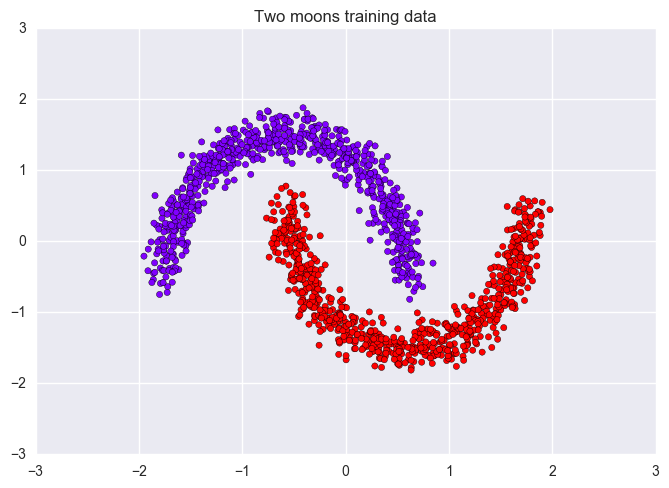

i= 0  kwargs= {'units': 4, 'input_shape': [2], 'kernel_initializer': 'normal', 'activation': 'relu'}
i= 1  kwargs= {'units': 4, 'activation': 'relu', 'kernel_initializer': 'normal'}
i= 2  kwargs= {'units': 1, 'activation': 'sigmoid', 'kernel_initializer': 'normal'}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________
227520/227520 [==============================] - 0s


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


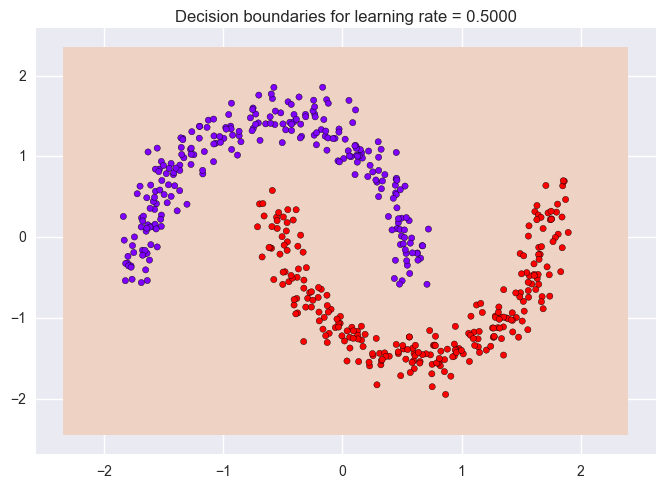

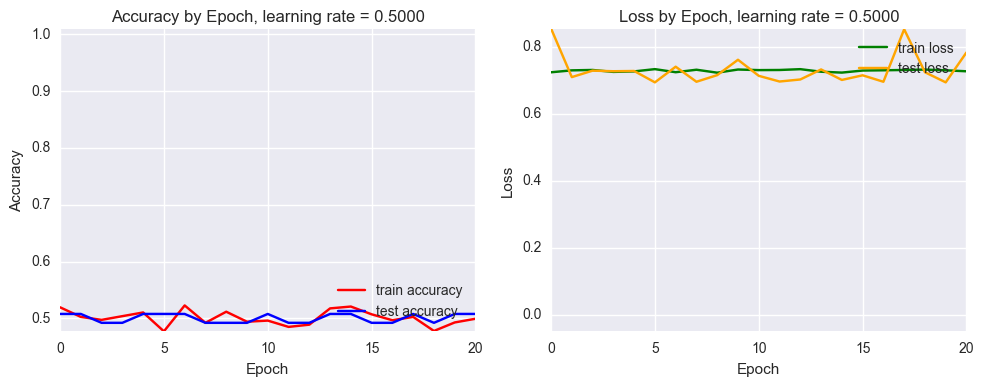

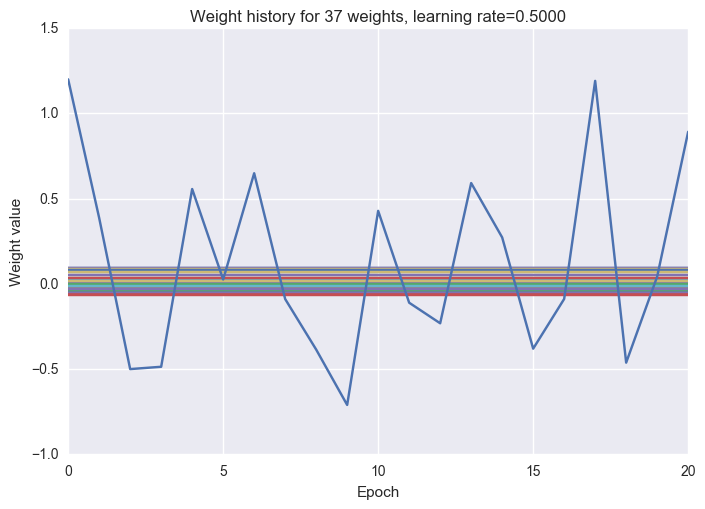

i= 0  kwargs= {'units': 4, 'input_shape': [2], 'kernel_initializer': 'normal', 'activation': 'relu'}
i= 1  kwargs= {'units': 4, 'activation': 'relu', 'kernel_initializer': 'normal'}
i= 2  kwargs= {'units': 1, 'activation': 'sigmoid', 'kernel_initializer': 'normal'}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 5         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________
227520/227520 [==============================] - 0s


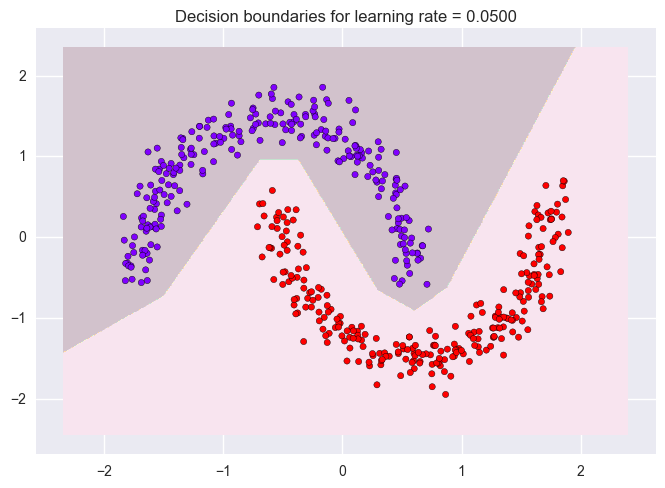

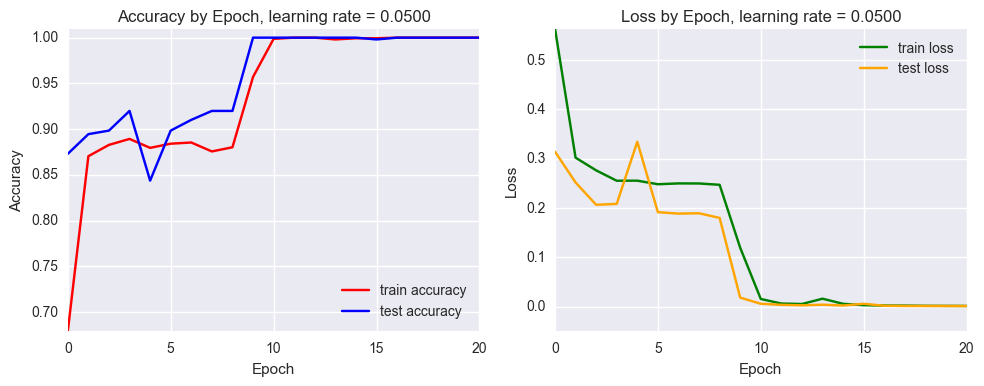

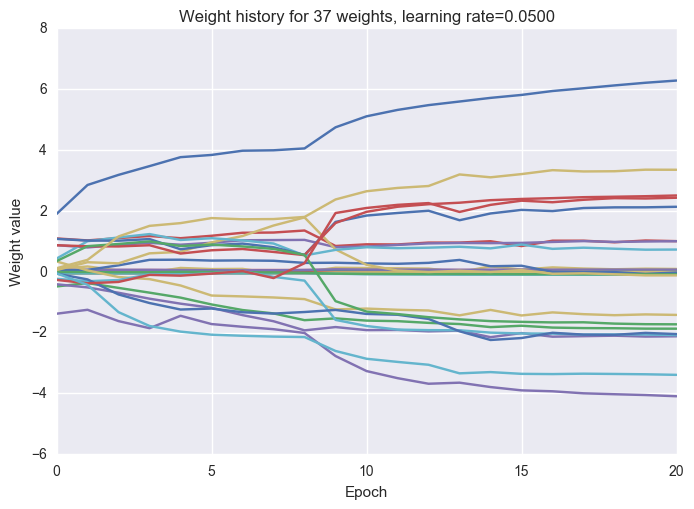

i= 0  kwargs= {'units': 4, 'input_shape': [2], 'kernel_initializer': 'normal', 'activation': 'relu'}
i= 1  kwargs= {'units': 4, 'activation': 'relu', 'kernel_initializer': 'normal'}
i= 2  kwargs= {'units': 1, 'activation': 'sigmoid', 'kernel_initializer': 'normal'}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 4)                 12        
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 5         
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________
227520/227520 [==============================] - 0s


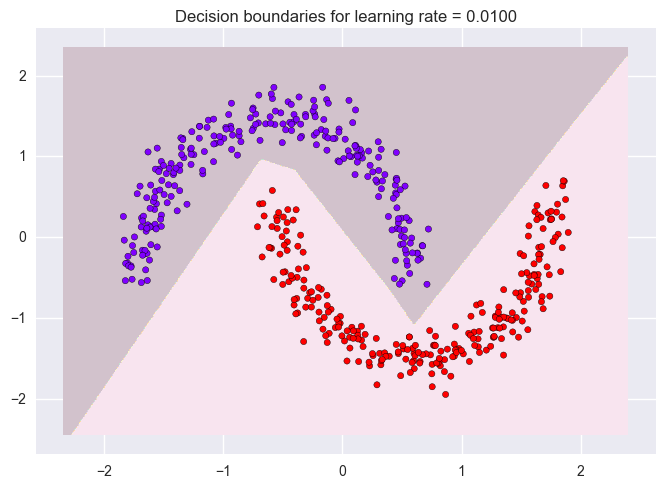

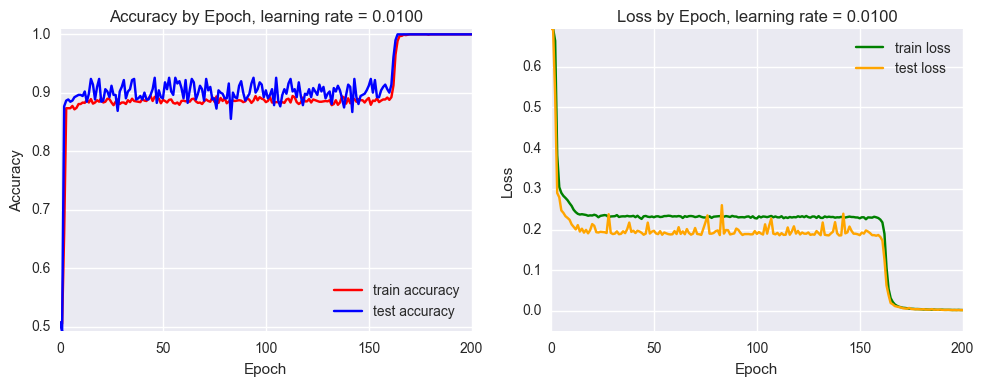

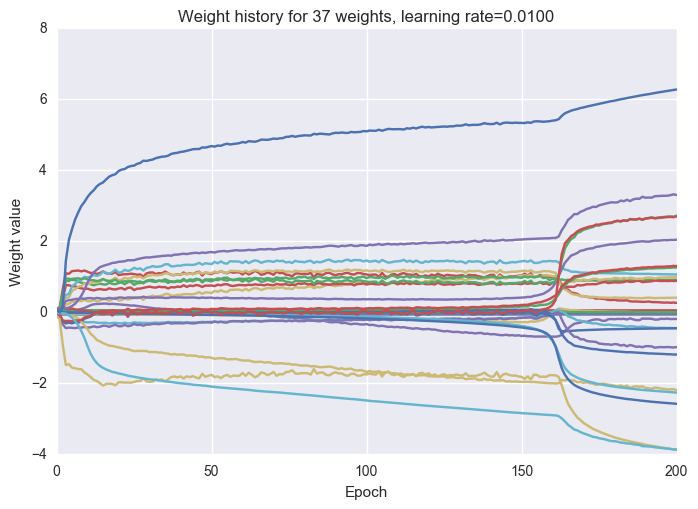

In [14]:
np.random.seed(random_seed)
(X_train, X_test, y_train, y_test) = make_training_data()
plot_training_data(X_train, y_train)

layer_sizes = [4, 4, 1]
epochs = [21, 21, 201] 
etas = [0.5, 0.05, 0.01] 
for (num_epochs, eta) in zip(epochs, etas):

    (model, layer_list, weight_history, history_list) = build_and_run_model(num_epochs, layer_sizes, eta)

    plot_decision_boundary(X_test, y_test, eta, lambda x: model.predict_classes(x, batch_size=len(x)))

    show_history_graphs(history_list, eta)

    (weights_matrix, num_weights) = build_weights_matrix(weight_history, num_epochs)
    num_weights_to_graph = num_weights
    graph_changed_weights(weights_matrix, num_weights, num_weights_to_graph, eta)